In [1]:
import torch.nn as nn
import torch
import torch.utils.data.dataloader as dataloader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchmetrics import Accuracy, ConfusionMatrix
from torch import optim
from torchsummary import summary
from torch.nn import functional as F
from sklearn.metrics import classification_report
import sklearn.exceptions as ske
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import warnings
import datetime
from PIL import Image
img_size_x = 640
img_size_y = 480
warnings.filterwarnings("ignore")

In [2]:
# Model classes
class Residual(nn.Module): 
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet():
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)
    def __init__(self, arch, num_classes=10):
        self.model = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.model.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.model.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))

class ResNet18(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), num_classes)

class ResNet26(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((4, 64), (4, 128), (4, 256), (4, 512)), num_classes)

class ResNet32(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((5, 64), (5, 128), (6, 256), (6, 512)), num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [3]:
#Model Summary
RN18 = ResNet18(num_classes=7).model
RN18.to(device)
summary(RN18,(1,img_size_x,img_size_y))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 240]           3,200
       BatchNorm2d-2         [-1, 64, 320, 240]             128
              ReLU-3         [-1, 64, 320, 240]               0
         MaxPool2d-4         [-1, 64, 160, 120]               0
            Conv2d-5         [-1, 64, 160, 120]          36,928
       BatchNorm2d-6         [-1, 64, 160, 120]             128
            Conv2d-7         [-1, 64, 160, 120]          36,928
       BatchNorm2d-8         [-1, 64, 160, 120]             128
          Residual-9         [-1, 64, 160, 120]               0
           Conv2d-10         [-1, 64, 160, 120]          36,928
      BatchNorm2d-11         [-1, 64, 160, 120]             128
           Conv2d-12         [-1, 64, 160, 120]          36,928
      BatchNorm2d-13         [-1, 64, 160, 120]             128
         Residual-14         [-1, 64, 1

In [4]:
#load model
best_model_dict = torch.load('best_model91.pt')
RN18.load_state_dict(best_model_dict['model_state_dict'])
RN18.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e

In [5]:
#start camera
cam = cv2.VideoCapture(0)

In [24]:
#Read image, resize convert to grayscale
result, image = cam.read()
resized = cv2.resize(image,(img_size_x, img_size_y),interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

In [25]:
#write processed image to png
cv2.imwrite("Final_image.png",gray)

True

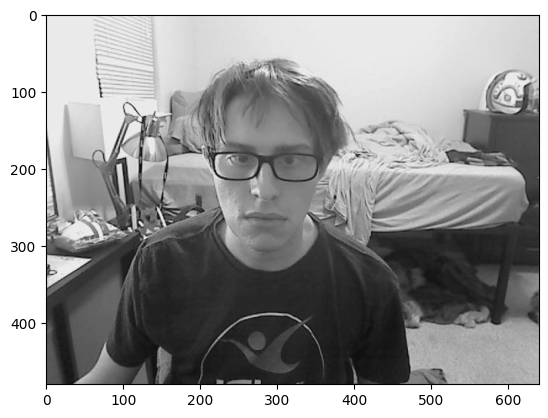

In [26]:
#load png as array and show to user
png_image = Image.open("Final_image.png")
png_image = png_image.convert('L')
png_array = np.array(png_image)
img = plt.imread("Final_image.png")
plt.imshow(img)
plt.set_cmap('gray')

In [27]:
#convert to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((img_size_x,img_size_y)),
     transforms.Normalize((0.5,), (0.5,),)])
png_tensor = transform(png_array)
png_tensor = torch.unsqueeze(png_tensor, 0)
png_tensor.size()
#print(png_tensor.unsqueeze(1))

torch.Size([1, 1, 640, 480])

In [28]:
#give tensor to gpu and then model
png_tensor = png_tensor.cuda()
#png_tensor.to(device)
outputs = RN18(png_tensor)
#outputs

In [29]:
#display model scores and predicted label
labels = ['anger','disgust','fear','happiness','neutral','sadness','surprise']
max_score = 0.0
scores = outputs.cpu().detach().numpy()
scores = scores[0]
print(scores)
label_index = 0
for i in range(0,7):
    if scores[i] > max_score:
        max_score = scores[i]
        label_index = i
        #print(f"max index {label_index} max score {max_score}")

print(f"predicted label: {labels[label_index]}")


[ 3.1010463   0.4604013  -0.54174304 -3.7138517  -0.53447896  3.81029
 -1.6490252 ]
predicted label: sadness
